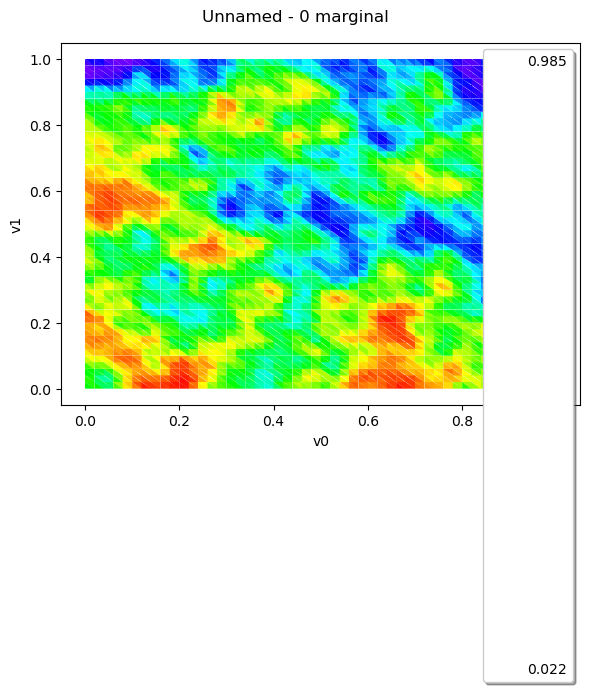

In [51]:
import openturns as ot
from openturns.viewer import View
import matplotlib.pyplot as plt

# (1)
mesher = ot.IntervalMesher([50, 50])
mesh = mesher.build(ot.Interval([0.0, 0.0], [1.0, 1.0]))

# (2)
cov = ot.ExponentialModel([0.2, 0.2], [1.5])
X = ot.GaussianProcess(cov, mesh)
field_X = X.getRealization()

# (3)
sigmoid = ot.SymbolicFunction(['z'], ['1/(1+exp(-z))'])
f = sigmoid(field_X)
field_f = ot.Field(mesh, f)

# Affichage 
graph = field_f.draw()
fig = plt.figure(figsize=(6, 6))
View(graph, figure=fig)
plt.tight_layout()
plt.show()
